Tài liệu này mang giấy phép Creative Commons Attribution (CC BY).
(c) Nguyễn Ngọc Sáng, Zhukovsky 7/2020.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

**Danh sách tài liệu tham khảo:**

*    [1. Eleuterio F. Toro] *`Riemann Solvers and Numerical Methods for Fluid Dynamics`*
*    [2. Katake Masatsuka] I *`do like CFD. Governing Equations and Exact Solutions`*
*    [3. F. Moukalled, L. Mangani, M. Darwish] *`The Finite Volume Method in Computational Fluid Dynamics. An Advanced Introduction with OpenFOAM and Matlab`*
*    [4. Randall J. Leveque] *`Finite-Volume Methods for Hyperbolic Problems`*
*    [5. H. K. Versteeg, W. Malalasekera] *`An introduction to Computational Fluid Dynamics. The Finite Volume Method`*



# Bài 25. Hệ phương trình Navier-Stokes, phương pháp Roe tính dòng đối lưu 

Hệ phương trình Navier-Stokes được viết rất cụ thể trong quyển sách Abramovich chương 2, đã được dịch và đăng trên trang [VnCFD](https://vncfdgroup.wordpress.com). Các bài mở đầu bao gồm:

* [Bài 1. Chuyển động của phần tử chất lỏng](https://vncfdgroup.wordpress.com/2012/04/09/bai-1-chuy%e1%bb%83n-d%e1%bb%99ng-c%e1%bb%a7a-ph%e1%ba%a7n-t%e1%bb%ad-ch%e1%ba%a5t-l%e1%bb%8fng/)

* [Bài 2. Phương trình liên tục](https://vncfdgroup.wordpress.com/2012/04/14/bai-2-ph%c6%b0%c6%a1ng-trinh-lien-t%e1%bb%a5c/)

* [Bài 3. Các lực tác dụng trong chất lỏng](https://vncfdgroup.wordpress.com/2012/04/14/bai-3-cac-l%e1%bb%b1c-tac-d%e1%bb%a5ng-trong-ch%e1%ba%a5t-l%e1%bb%8fng/)

* [Bài 4. Mối liên hệ giữa ứng suất và tốc độ biến dạng](https://vncfdgroup.wordpress.com/2012/04/14/bai-4-m%e1%bb%91i-lien-h%e1%bb%87-gi%e1%bb%afa-%e1%bb%a9ng-su%e1%ba%a5t-va-d%e1%bb%99-bi%e1%ba%bfn-d%e1%ba%a1ng/)

* [Bài 5. Phương trình Navier – Stokes](https://vncfdgroup.wordpress.com/2012/04/14/bai-5-ph%c6%b0%c6%a1ng-trinh-navier-stokes/)

* [Bài 6. Phương trình năng lượng](https://vncfdgroup.wordpress.com/2012/04/14/bai-6-ph%c6%b0%c6%a1ng-trinh-nang-l%c6%b0%e1%bb%a3ng/)


## 1. Hệ phương trình Navier-Stokes

Để tóm tắt hệ phương trình Navier-Stokes, trước hết ta nhớ lại **hệ phương trình Euler cho khí lý tưởng**:

$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial x} + \frac{\partial G}{\partial y} + \frac{\partial H}{\partial z} = 0 \qquad (1)$$
với 
\begin{align}
U & = \begin{pmatrix} \rho \\ \rho u \\ \rho v \\ \rho w \\ \rho e\end{pmatrix}, &
F & = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ \rho uv \\ \rho uw \\ \rho uh\end{pmatrix}, &
G & = \begin{pmatrix} \rho v \\ \rho vu \\ \rho v^2 + p \\ \rho vw \\ \rho vh\end{pmatrix}, &
H & = \begin{pmatrix} \rho w \\ \rho wu \\ \rho wv \\ \rho w^2 + p \\ \rho wh\end{pmatrix} &
\end{align}
trong đó: $h = e + \frac{p}{\rho}$, $e = \varepsilon + \frac{u^2+v^2+w^2}{2}$, $\varepsilon = \frac{p}{(\gamma-1)\rho}$; $\rho$ - khối lượng riêng; $u, v, w$ - vận tốc theo phương x, y, z; $p$ - áp suất;  $h$ - enthalpy; $e$ - năng lượng một đơn vị khối lượng chất khí; $\varepsilon$ - nội năng.

Trong phương trình (1), số hạng đầu gọi là **thành phần không ổn định (unsteady term)**, ba số hạng còn lại là **dòng đại lượng (khối lượng, động lượng, năng lượng) đi qua bề mặt thể tích kiểm soát**, được tạo ra bởi chuyển dịch vĩ mô của dòng, gọi là **thành phần đối lưu (convection term)**.

Điểm khác biệt giữa hai hệ phương trình Euler và Navier-Stokes nằm ở chính đối tượng mà chúng mô tả. **Hệ Navier-Stokes mô tả khí thực** do đó phải tính tới lực ma sát trong (lực nhớt), công của lực ma sát, quá trình trao đổi nhiệt (dẫn nhiệt). Hệ này có dạng:

$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial x} + \frac{\partial G}{\partial y} + \frac{\partial H}{\partial z} = 0 \qquad (2)$$
với 
\begin{align}
U & = \begin{pmatrix} \rho \\ \rho u \\ \rho v \\ \rho w \\ \rho e\end{pmatrix}, &
F & = \begin{pmatrix} \rho u \\ \rho u^2+p\\ \rho uv \\ \rho uw \\ \rho uh\end{pmatrix} +
\begin{pmatrix} 0 \\ \tau_{xx}\\ \tau_{xy} \\ \tau_{xz} \\ u\tau_{xx}+v\tau_{xy}+w\tau_{xz}+q_x\end{pmatrix}, &
\end{align}

\begin{align}
G & = \begin{pmatrix} \rho v \\ \rho vu \\ \rho v^2+p \\ \rho vw \\ \rho vh \end{pmatrix} + 
\begin{pmatrix} 0 \\ \tau_{yx} \\ \tau_{yy} \\ \tau_{yz} \\ u\tau_{yx}+v\tau_{yy}+w\tau_{yz}+q_y\end{pmatrix}, &
H & = \begin{pmatrix} \rho w \\ \rho wu \\ \rho wv \\ \rho w^2+p \\ \rho wh \end{pmatrix} +
\begin{pmatrix} 0 \\ \tau_{zx} \\ \tau_{zy} \\ \tau_{zz} \\ u\tau_{zx}+v\tau_{zy}+w\tau_{zz}+q_z\end{pmatrix} &
\end{align}


Trong đó, tensor lực nhớt:
\begin{align}
\tau & = \begin{pmatrix} 
\tau_{xx} & \tau_{xy} & \tau_{xz} \\
\tau_{yx} & \tau_{yy} & \tau_{yz} \\
\tau_{zx} & \tau_{zy} & \tau_{zz} \\
\end{pmatrix}
\end{align}
với thành phần theo phương tiếp tuyến:

$$\tau_{xy}=\tau_{yx}=-\mu\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}\right)$$
$$\tau_{yz}=\tau_{zy}=-\mu\left(\frac{\partial v}{\partial z}+\frac{\partial w}{\partial y}\right)$$
$$\tau_{zx}=\tau_{xz}=-\mu\left(\frac{\partial w}{\partial x}+\frac{\partial u}{\partial z}\right)$$

và thành phần theo phương pháp tuyến:
$$\tau_{xx}=-2\mu\left[\frac{\partial u}{\partial x} - \frac{1}{3}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}+\frac{\partial w}{\partial z}\right)\right]$$

$$\tau_{yy}=-2\mu\left[\frac{\partial v}{\partial y} - \frac{1}{3}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}+\frac{\partial w}{\partial z}\right)\right]$$

$$\tau_{zz}=-2\mu\left[\frac{\partial w}{\partial z} - \frac{1}{3}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}+\frac{\partial w}{\partial z}\right)\right]$$

hệ số nhớt động lực học:
$$\mu = \mu_0\left(\frac{T}{T_0}\right)^{1.5} \frac{T_0+C}{T+C}; T_0=273 [K], C=122 [K], \mu_0=1.72.10^{-5} [Pa.s]. $$


Mật độ dòng nhiệt của quá trình dẫn nhiệt:
$$q_x = -\lambda \frac{\partial T}{\partial x}, q_y = -\lambda \frac{\partial T}{\partial y}, q_z = -\lambda \frac{\partial T}{\partial z},$$
hệ số dẫn nhiệt $\lambda$ tính thông qua số Prandtl:

$$Pr = \frac{c_p \mu}{\lambda}=\frac{\gamma R \mu}{\lambda (\gamma-1)}$$

với không khí trong khoảng nhiệt độ từ 200K tới 1000K, $Pr=0.72$.

Mật độ dòng nhiệt có thể tính theo công thức:

$$q = -\lambda grad T = -\frac{\mu}{Pr(\gamma-1)}grad (c^2) = -\frac{\gamma \mu}{Pr(\gamma-1)}grad (p/\rho), \quad c=\sqrt{\frac{\gamma p}{\rho}}=\sqrt{\gamma R T}$$ 

So với hệ phương trình Euler, trong Navier-Stokes (2) **dòng qua mặt** gồm hai thành phần: **thành phần đối lưu (convection term)** và **thành phần khuếch tán (diffusion term)**. Thành phần khuếch tán được tạo ra bởi chuyển dịch, va chạm của các phân tử chất khí. 

Như vậy, để giải hệ Navier-Stokes ta cần phải thêm vào euler solver **dòng khuếch tán**.


# 2. Phương pháp Roe tính dòng đối lưu

Có nhiều phương pháp tính dòng đối lưu, ở phần 2 *Thực hành CFD với Python* chúng ta đã tìm hiểu phương pháp Godunov: tìm nghiệm biến nguyên thủy của bài toán phân ra gián đoạn Riemann, thông qua đó để tính dòng qua mặt. Ở phần 3, ta đã sử dụng phương pháp Roe để tính dòng qua mặt nhưng chưa tìm hiểu về nó.

Các phương pháp giải bài toán Riemann được viết rất cụ thể trong các quyển sách tham khảo được liệt kê ở trên. Sau đây ta cùng tìm hiểu về phương pháp Roe.

Xét hệ phương trình vi phân:

$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial x} =0$$

Phương trình này có thể viết lại ở dạng:

$$\frac{\partial U}{\partial t} + A(U)\frac{\partial U}{\partial x} =0$$
với ma trận Jacobi $A(U)=\frac{\partial F}{\partial U}$.

Để giải bài toán Riemann, thay vì sử dụng ma trận chuẩn xác Jacobi A(U) phương pháp xấp xỉ Roe đề xuất sử dụng ma trận hằng số Jacobi $\hat A(U_L, U_R)$. Đối với hệ hyperbolic của $m$ định luật bảo toàn ($m$ phương trình), ma trận $\hat A$ phải thỏa mãn các tính chất sau:

* 1. có các trị riêng là số thực  $\hat\lambda_1 \le \hat\lambda_2 \le... \le \hat\lambda_m$ và
     có hệ đầy đủ vector riêng bên phải độc lập tuyến tính $\hat R_1, \hat R_2, ..., \hat R_m$ 
* 2. $\hat A(U,U) = A(U)$
* 3. $F(U_R)-F(U_L) = \hat A(U_R-U_L)$

Khi đó ta có: 
$$\hat A=\hat R \hat\Lambda \hat R^{-1}$$

với $\hat R, \hat R^{-1}$ là ma trận cột các vector riêng bên phải và nghịch đảo của nó, $\hat \Lambda$ là ma trận đường chéo các trị riêng.

Giá trị của Jacobian $\hat A$ được xác định, sử dụng các giá trị trung bình Roe:

\begin{align}
\hat \rho &= \sqrt{\rho_L \rho_R} \\
\hat u &= \frac{\sqrt{\rho_L}u_L + \sqrt{\rho_R}u_R}{\sqrt{\rho_L}+\sqrt{\rho_R}} \\
\hat v &= \frac{\sqrt{\rho_L}v_L + \sqrt{\rho_R}v_R}{\sqrt{\rho_L}+\sqrt{\rho_R}} \\
\hat h &= \frac{\sqrt{\rho_L}h_L + \sqrt{\rho_R}h_R}{\sqrt{\rho_L}+\sqrt{\rho_R}} \\
\hat c &= \sqrt{(\gamma-1)(\hat h - {\hat q})} \\
\hat q &= (\hat u^2 + \hat v^2)/2
\end{align}


### Công thức tính dòng qua mặt

Trước hết ta biểu diễn hiệu $U_R-U_L$ ở dạng:

$$\Delta U = U_R-U_L = \sum_{i=1}^m \hat \alpha_i \hat R^i$$

Khi đó, giá trị $U_{i+1/2}, F_{i+1/2}$ có thể tính theo 1 trong hai công thức sau:
* Công thức 1:
\begin{align}
U_{i+1/2} &= \frac{1}{2}(U_L + U_R) - \frac{1}{2}\sum_{i=i}^m sign(\hat \lambda_i) \hat \alpha_i \hat R^i \\
F_{i+1/2} &= \frac{1}{2}(F_L + F_R) - \frac{1}{2}\sum_{i=i}^m |\hat \lambda_i| \hat \alpha_i \hat R^i
\end{align}
* Công thức 2:
\begin{align}
U_{i+1/2} &= \frac{1}{2}(U_L + U_R) - \frac{1}{2}R sign(\hat \Lambda) \hat R^{-1} \\
F_{i+1/2} &= \frac{1}{2}(F_L + F_R) - \frac{1}{2}R |\hat \Lambda| \hat R^{-1}
\end{align}

Trong đó $sign(\hat \lambda), |\hat \lambda|$ lần lượt là dấu và trị tuyệt đối của $\hat \lambda$.

Làm thế nào để có công thức tính Jacobian, trị riêng, vector riêng hay $\alpha$? 

Xét trường hợp cụ thể sau.
### Bài toán hai chiều 
Cụ thể, xét bài toán hai chiều:
\begin{align}
U & = \begin{pmatrix} \rho \\ \rho u \\ \rho v \\ \rho e\end{pmatrix}, &
F & = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ \rho uv  \\ \rho uh\end{pmatrix}, &
G & = \begin{pmatrix} \rho v \\ \rho vu \\ \rho v^2 + p \\ \rho vh\end{pmatrix} &
\end{align}

Vector dòng vuông góc với mặt (normal flux) hay là hình chiếu của dòng theo phương pháp tuyến bề mặt $n=(n_x, n_y)^T$ được xác định như sau:

\begin{equation}
F_n = [F,G].n=Fn_x+Gn_y=\begin{pmatrix} \rho V_n \\ \rho V_nu+pn_x \\ \rho V_nv+pn_y \\ \rho V_nh \end{pmatrix}
\end{equation}

với $V_n=un_x+vn_y$. Ma trận Jacobi $A_n=An_x + Bn_y=\frac{\partial F}{\partial U}n_x + \frac{\partial G}{\partial U}n_y$

## 3. Sympy, Jacobian

Để tìm ma trận Jacobi cũng như trị riêng, vector riêng ta sẽ biến đổi toán học bằng sympy.

In [1]:
# Gọi thư viện sympy 
from sympy import*

init_printing()

In [2]:
# Làm quen với sympy:

# Khai báo các kí tự sẽ sử dụng để biến đổi toán học 
r, u, v, p, h, g, q, c = symbols('rho u v p h gamma q c', real=True)
u1, u2, u3, u4 = symbols('u_1 u_2 u_3 u_4', real=True)
nx, ny, Vn = symbols('n_x n_y V_n', real=True)

# Khai báo các vector ở dạng matrận 
# q = 0.5(u*u+v*v)

P = Matrix([r, u, v, p])
U = Matrix([r, r*u, r*v, p/(g-1) + r*q])
F = Matrix([r*u, r*u*u + p, r*u*v, (g*p/(g-1) + r*q)*u])
G = Matrix([r*v, r*v*u, r*v*v + p, (g*p/(g-1) + r*q)*v])

# in ra màn hình 
P, U, F, G

⎛                    ⎡      ρ⋅u      ⎤  ⎡      ρ⋅v      ⎤⎞
⎜     ⎡     ρ     ⎤  ⎢               ⎥  ⎢               ⎥⎟
⎜⎡ρ⎤  ⎢           ⎥  ⎢          2    ⎥  ⎢     ρ⋅u⋅v     ⎥⎟
⎜⎢ ⎥  ⎢    ρ⋅u    ⎥  ⎢   p + ρ⋅u     ⎥  ⎢               ⎥⎟
⎜⎢u⎥  ⎢           ⎥  ⎢               ⎥  ⎢          2    ⎥⎟
⎜⎢ ⎥, ⎢    ρ⋅v    ⎥, ⎢     ρ⋅u⋅v     ⎥, ⎢   p + ρ⋅v     ⎥⎟
⎜⎢v⎥  ⎢           ⎥  ⎢               ⎥  ⎢               ⎥⎟
⎜⎢ ⎥  ⎢  p        ⎥  ⎢  ⎛ γ⋅p       ⎞⎥  ⎢  ⎛ γ⋅p       ⎞⎥⎟
⎜⎣p⎦  ⎢───── + q⋅ρ⎥  ⎢u⋅⎜───── + q⋅ρ⎟⎥  ⎢v⋅⎜───── + q⋅ρ⎟⎥⎟
⎝     ⎣γ - 1      ⎦  ⎣  ⎝γ - 1      ⎠⎦  ⎣  ⎝γ - 1      ⎠⎦⎠

Cách xác định ma trận Jacobi (Jacobian):

\begin{equation}
A=\frac{\partial F}{\partial U}=
\frac{\partial(f_1, f_2, f_3, f_4)}{\partial(u_1, u_2, u_3, u_4)}=
\begin{pmatrix}
\frac{\partial f_1}{\partial u_1} & \frac{\partial f_1}{\partial u_2} & \frac{\partial f_1}{\partial u_3} & \frac{\partial f_1}{\partial u_4} \\
\frac{\partial f_2}{\partial u_1} & \frac{\partial f_2}{\partial u_2} & \frac{\partial f_2}{\partial u_3} & \frac{\partial f_2}{\partial u_4} \\
\frac{\partial f_3}{\partial u_1} & \frac{\partial f_3}{\partial u_2} & \frac{\partial f_3}{\partial u_3} & \frac{\partial f_3}{\partial u_4} \\
\frac{\partial f_4}{\partial u_1} & \frac{\partial f_4}{\partial u_2} & \frac{\partial f_4}{\partial u_3} & \frac{\partial f_4}{\partial u_4} \\
\end{pmatrix}
\end{equation}

In [3]:
# Để tìm ma trận Jacobi ta chuyển sang sử dụng các biến (u1,u2,u3,u4)
U = Matrix([u1, u2, u3, u4])

# Khi đó áp suất p được tính theo công thức 
pf = (u4-(u2*u2+u3*u3)/(2*u1))*(g-1)

# Biến đổi ta có: 
F = Matrix([u2, u2*u2/u1 + pf, u2*u3/u1, (u4+pf)*u2/u1])
G = Matrix([u3, u3*u2/u1, u3*u3/u1 + pf, (u4+pf)*u3/u1])

# Tìm matrận Jacobi
A = F.jacobian(U)
B = G.jacobian(U)

# Để đưa về dạng nguyên bản ta thực hiện bước thay biến 
args = ([u1, r], [u2, r*u], [u3, r*v], [u4, p/(g-1)+0.5*r*(u*u+v*v)])

# Dùng hàm simplify để rút gọn công thức, in ra màn hình 
A, B = simplify(A.subs(args)), simplify(B.subs(args))
A, B

⎛⎡                                  0                                         
⎜⎢                                                                            
⎜⎢                                     ⎛ 2    2⎞                              
⎜⎢                         2   (γ - 1)⋅⎝u  + v ⎠                              
⎜⎢                      - u  + ─────────────────                              
⎜⎢                                     2                                      
⎜⎢                                                                            
⎜⎢                                -u⋅v                                        
⎜⎢                                                                            
⎜⎢  ⎛ 2    2    2    2                  2          2        2        2⎞       
⎜⎢u⋅⎝γ ⋅ρ⋅u  + γ ⋅ρ⋅v  - 2⋅γ⋅p - 3⋅γ⋅ρ⋅u  - 3⋅γ⋅ρ⋅v  + 2⋅ρ⋅u  + 2⋅ρ⋅v ⎠  - 2⋅γ
⎜⎢─────────────────────────────────────────────────────────────────────  ─────
⎝⎣                             2⋅ρ⋅(γ - 1)          

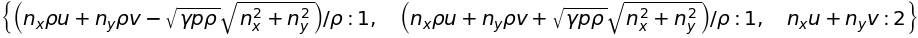

In [4]:
# Jacobian An
An = A*nx+B*ny

# Tìm trị riêng 
simplify(An.eigenvals())

Như vậy Jacobian An có 4 trị riêng:
$$\lambda_1=\lambda_2=V_n, \lambda_3=V_n-c, \lambda_4=V_n+c$$
với vận tốc âm thanh $c=\sqrt{\gamma p/ \rho}$

Để tìm vector riêng bên phải, bên trái có thể dùng hàm **An.eigenvects(), An.left_eigenvects()**, tuy nhiên công thức thu được sẽ rất rất dài vì không được rút gọn. Vì vậy ta sẽ thu gọn Jacobian An và tính toán thủ công.

In [5]:
# Rút gọn công thức ta có hai ma trận Jacobi sau:
A = Matrix([[0, 1, 0, 0], [(g-1)*q-u*u, (3-g)*u, (1-g)*v, g-1],\
            [-u*v, v, u, 0], [((g-1)*q-h)*u, h+(1-g)*u*u, (1-g)*u*v, g*u]])

B = Matrix([[0, 0, 1, 0], [-u*v, v, u, 0], \
                [(g-1)*q-v*v, (1-g)*u, (3-g)*v, g-1],\
                [((g-1)*q-h)*v, (1-g)*u*v, h+(1-g)*v*v, g*v]]) 
# In ra màn hình 
# A, B

In [6]:
# Jacobian An 
An = A*nx+B*ny
An

⎡                      0                                           nₓ         
⎢                                                                             
⎢           ⎛             2⎞                                                  
⎢        nₓ⋅⎝q⋅(γ - 1) - u ⎠ - n_y⋅u⋅v                    nₓ⋅u⋅(-γ + 3) + n_y⋅
⎢                                                                             
⎢                      ⎛             2⎞                                       
⎢        -nₓ⋅u⋅v + n_y⋅⎝q⋅(γ - 1) - v ⎠                   nₓ⋅v + n_y⋅u⋅(-γ + 1
⎢                                                                             
⎢                                                   ⎛     2         ⎞         
⎣nₓ⋅u⋅(-h + q⋅(γ - 1)) + n_y⋅v⋅(-h + q⋅(γ - 1))  nₓ⋅⎝h + u ⋅(-γ + 1)⎠ + n_y⋅u⋅

                              n_y                           0        ⎤
                                                                     ⎥
                                                                   

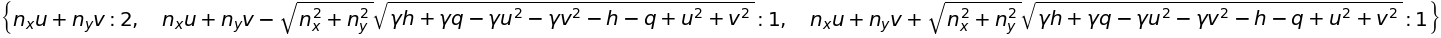

In [7]:
# Kiểm tra lại trị riêng 
An.eigenvals()

Rút gọn ta được 4 trị riêng như ở trên: 
$$\lambda_1=\lambda_2=V_n, \lambda_3=V_n-c, \lambda_4=V_n+c$$    

In [8]:
# Rút gọn công thức ta có Jacobian An:
An = Matrix([[0 , nx , ny , 0], \
            [(g-1)*q*nx - Vn*u, (2-g)*u*nx + Vn, (1-g)*v*nx + u*ny , (g-1)*nx], \
            [(g-1)*q*ny - Vn*v, (1-g)*u*ny + v*nx, (2-g)*v*ny + Vn , (g-1)*ny], \
            [((g-1)*q - h)*Vn, (1-g)*Vn*u + h*nx , (1-g)*Vn*v + h*ny, g*Vn]])

# Tìm vector riêng bên phải:
# 1. trường hợp trị riêng bằng Vn
A1 = An - Vn*eye(4) # = An - lambda*I
A1

⎡         -Vₙ                    nₓ                     n_y                0  
⎢                                                                             
⎢-Vₙ⋅u + nₓ⋅q⋅(γ - 1)       nₓ⋅u⋅(-γ + 2)      nₓ⋅v⋅(-γ + 1) + n_y⋅u  nₓ⋅(γ - 
⎢                                                                             
⎢-Vₙ⋅v + n_y⋅q⋅(γ - 1)  nₓ⋅v + n_y⋅u⋅(-γ + 1)     n_y⋅v⋅(-γ + 2)      n_y⋅(γ -
⎢                                                                             
⎣ Vₙ⋅(-h + q⋅(γ - 1))   Vₙ⋅u⋅(-γ + 1) + h⋅nₓ   Vₙ⋅v⋅(-γ + 1) + h⋅n_y   Vₙ⋅γ - 

   ⎤
   ⎥
1) ⎥
   ⎥
 1)⎥
   ⎥
Vₙ ⎦

Vì trị riêng Vn lặp lại hai lần nên tương ứng ta lấy hai vector riêng bên phải. Dễ dàng dàng nhận thấy hai vector này có dạng:

$R_1 = (1, u, v, \tau_1)^T, R_2 = (0, -ny, nx, \tau_1)^T$

Chúng ta cần tìm $\tau_1$ cho từng trường hợp. Để làm điều này ta sử dụng hàm gauss_jordan_solve để hỗ trợ. Cách làm như sau:

In [9]:
B = Matrix([0, 0, 0, 0])

Ri, params = A1.gauss_jordan_solve(B)
simplify(Ri)

⎡nₓ⋅τ₀⋅v - nₓ⋅τ₁ - n_y⋅τ₀⋅u⎤
⎢──────────────────────────⎥
⎢       -Vₙ⋅u + nₓ⋅q       ⎥
⎢                          ⎥
⎢Vₙ⋅τ₀⋅v - Vₙ⋅τ₁ - n_y⋅q⋅τ₀⎥
⎢──────────────────────────⎥
⎢       -Vₙ⋅u + nₓ⋅q       ⎥
⎢                          ⎥
⎢            τ₀            ⎥
⎢                          ⎥
⎣            τ₁            ⎦

Đồng nhất hạng tử Ri=R1, Ri=R2 ta tìm được $\tau_1$ lần lượt bằng $q; n_xv-n_yu$. Như vậy hai vector riêng bên phải:

$$R_1 = (1, u, v, q)^T$$ $$R_2 = (0, -ny, nx, n_xv-n_yu)^T$$

In [10]:
# 2. trường hợp trị riêng  bằng Vn-c
A2 = An - (Vn-c)*eye(4)
A2

⎡       -Vₙ + c                  nₓ                     n_y                 0 
⎢                                                                             
⎢-Vₙ⋅u + nₓ⋅q⋅(γ - 1)     c + nₓ⋅u⋅(-γ + 2)    nₓ⋅v⋅(-γ + 1) + n_y⋅u   nₓ⋅(γ -
⎢                                                                             
⎢-Vₙ⋅v + n_y⋅q⋅(γ - 1)  nₓ⋅v + n_y⋅u⋅(-γ + 1)   c + n_y⋅v⋅(-γ + 2)     n_y⋅(γ 
⎢                                                                             
⎣ Vₙ⋅(-h + q⋅(γ - 1))   Vₙ⋅u⋅(-γ + 1) + h⋅nₓ   Vₙ⋅v⋅(-γ + 1) + h⋅n_y  Vₙ⋅γ - V

     ⎤
     ⎥
 1)  ⎥
     ⎥
- 1) ⎥
     ⎥
ₙ + c⎦

In [11]:
# Không còn dùng được hàm gauss_jordan_solve để giải 
A2.gauss_jordan_solve(B)

⎛⎡0⎤    ⎞
⎜⎢ ⎥    ⎟
⎜⎢0⎥    ⎟
⎜⎢ ⎥, []⎟
⎜⎢0⎥    ⎟
⎜⎢ ⎥    ⎟
⎝⎣0⎦    ⎠

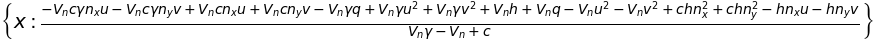

In [12]:
# Vector riêng có dạng Ri = (1, u-c*nx, v-c*ny, x).
x = symbols('x', real=True)
Ri = Matrix([1, u-c*nx, v-c*ny, x])

# Tìm x như sau:
fx = A2[3, :]*Ri # = 0

solve(fx, x)

Rút gọn tử số ta được: $-V_n^2c(\gamma-1)+V_nq(\gamma-1)+ch$. Thay $q=h-c^2/(\gamma-1)$, tử số bằng:

$-V_n^2c(\gamma-1) + V_n(\gamma-1)h - V_nc^2+ch = (V_n(\gamma-1)+c)(h-V_nc)$

Như vậy $x=h-V_nc$. 

Ta có vector riêng tương ứng trị riêng $\lambda = V_n - c$: 
$$R_3=(1, u-cn_x, v-cn_y, h-V_nc)^T$$
Tương tự, vector riêng tương ứng trị riêng $\lambda = V_n + c$: 
$$R_4 = (1, u+cn_x, v+cn_y, n+V_nc)^T$$

In [13]:
# Kiểm tra lại vector riêng R3
Ri = Matrix([1, u-c*nx, v-c*ny, h-Vn*c])
fx = A2[2, :]*Ri

args = ([Vn, u*nx+v*ny], [q, 0.5*(u*u+v*v)], [h, 0.5*(u*u+v*v) + c*c/(g-1)])
simplify(fx.subs(args)) # = 0 -> đúng 

⎡    ⎛    2      2    ⎞⎤
⎣c⋅v⋅⎝- nₓ  - n_y  + 1⎠⎦

In [14]:
fx = A2[1, :]*Ri
simplify(fx.subs(args)) # = 0 -> đúng 

⎡    ⎛    2      2    ⎞⎤
⎣c⋅u⋅⎝- nₓ  - n_y  + 1⎠⎦

In [15]:
# Ta có ma trận đường chéo trị riêng
E = diag(abs(Vn-c), abs(Vn), abs(Vn), abs(Vn+c))
E

⎡│Vₙ - c│   0     0       0    ⎤
⎢                              ⎥
⎢   0      │Vₙ│   0       0    ⎥
⎢                              ⎥
⎢   0       0    │Vₙ│     0    ⎥
⎢                              ⎥
⎣   0       0     0    │Vₙ + c│⎦

In [16]:
# Tương ứng ma trận vector riêng bên phải 
R = Matrix([[1, 1, 0, 1], [u-c*nx, u, -ny, u+c*nx],\
            [v-c*ny, v, nx, v+c*ny], [h-Vn*c, q, -u*ny+v*nx, h+Vn*c]])

R

⎡    1       1       0            1    ⎤
⎢                                      ⎥
⎢-c⋅nₓ + u   u      -n_y      c⋅nₓ + u ⎥
⎢                                      ⎥
⎢-c⋅n_y + v  v       nₓ       c⋅n_y + v⎥
⎢                                      ⎥
⎣-Vₙ⋅c + h   q  nₓ⋅v - n_y⋅u  Vₙ⋅c + h ⎦

Kết quả này hoàn toàn trùng khớp với kết quả trong sách của **Katate Masatsuka** trang 69. Tương tự ta có ma trận vector riêng bên trái:

In [17]:
L = Matrix([[((g-1)*q/c**2 + Vn/c)/2, -((g-1)*u/c**2 + nx/c)/2, -((g-1)*v/c**2+ny/c)/2, (g-1)/(2*c**2)], \
            [1-(g-1)*q/c**2, (g-1)*u/c**2, (g-1)*v/c**2, -(g-1)/c**2], \
            [u*ny-v*nx, -ny, nx, 0], \
            [((g-1)*q/c**2-Vn/c)/2, -((g-1)*u/c**2-nx/c)/2, -((g-1)*v/c**2-ny/c)/2, (g-1)/(2*c**2)]])

L

⎡  Vₙ   q⋅(γ - 1)      nₓ   u⋅(γ - 1)    n_y   v⋅(γ - 1)  γ - 1 ⎤
⎢ ─── + ─────────   - ─── - ─────────  - ─── - ─────────  ───── ⎥
⎢ 2⋅c         2       2⋅c         2      2⋅c         2        2 ⎥
⎢          2⋅c                 2⋅c                2⋅c      2⋅c  ⎥
⎢                                                               ⎥
⎢      q⋅(γ - 1)        u⋅(γ - 1)          v⋅(γ - 1)      -γ + 1⎥
⎢  1 - ─────────        ─────────          ─────────      ──────⎥
⎢           2                2                  2            2  ⎥
⎢          c                c                  c            c   ⎥
⎢                                                               ⎥
⎢  -nₓ⋅v + n_y⋅u          -n_y                nₓ            0   ⎥
⎢                                                               ⎥
⎢   Vₙ   q⋅(γ - 1)    nₓ   u⋅(γ - 1)    n_y   v⋅(γ - 1)   γ - 1 ⎥
⎢- ─── + ─────────   ─── - ─────────    ─── - ─────────   ───── ⎥
⎢  2⋅c         2     2⋅c         2      2⋅c         2         2 ⎥
⎣         

In [18]:
# Kiểm tra lại kết quả, tính tích R*L
RL = simplify(R*L)
simplify(RL.subs(args))

⎡                                   1                                         
⎢                                                                             
⎢                           ⎛    2      2    ⎞                                
⎢                         u⋅⎝- nₓ  - n_y  + 1⎠                                
⎢                                                                             
⎢                           ⎛    2      2    ⎞                                
⎢                         v⋅⎝- nₓ  - n_y  + 1⎠                                
⎢                                                                             
⎢        2  2         2  2          2  2          2  2        2        2    ⎛ 
⎣- 1.0⋅nₓ ⋅u  - 1.0⋅nₓ ⋅v  - 1.0⋅n_y ⋅u  - 1.0⋅n_y ⋅v  + 1.0⋅u  + 1.0⋅v   u⋅⎝n

    0                   0           0⎤
                                     ⎥
  2      2                           ⎥
nₓ  + n_y               0           0⎥
                                     ⎥
              

Rút gọn ta được $RL=I$, hay $L=R^{-1}$.

Như vậy ta đã có công thức của $R, \Lambda, L$, để tính dòng theo công thức 1, cần xác định công thức tính $\alpha_i$. Cách làm như trong sách của **Toro, trang 364**:

\begin{align}
\hat\alpha_1 &= \frac{1}{2\hat c^2}[\Delta p-\hat \rho \hat c \Delta V_n]\\
\hat\alpha_2 &= \Delta \rho -\Delta p/\hat c^2 \\
\hat\alpha_3 &= \hat \rho \Delta V_{\tau}\\
\hat\alpha_4 &= \frac{1}{2\hat c^2}[\Delta p+\hat \rho \hat c \Delta V_n]\\
\end{align}

với $V_n = Vn = (u,v)(n_x,n_y) = un_x+vn_y; \quad V_{\tau} = V{\tau} = (u,v)(-n_y,n_x) = -un_y+vn_x$.

## 5. So sánh hai công thức tính dòng qua mặt

Viết hai chương trình nhỏ để kiểm tra phương pháp tính dòng.

In [1]:
from numpy import diag, array, dot

In [2]:
# Công thức 1
def flux_roe_1(Pl, Pr, N):
    # Xác định các thông số trái, phải 
    rl, ul, vl, pl = Pl[0], Pl[1], Pl[2], Pl[3]
    rr, ur, vr, pr = Pr[0], Pr[1], Pr[2], Pr[3]
    nx, ny = N[0], N[1]
    
    g, gm1 = 1.4, 0.4
    cl = (g*pl/rl)**0.5
    cr = (g*pr/rr)**0.5
    hl = 0.5*(ul*ul+vl*vl)+cl*cl/gm1
    hr = 0.5*(ur*ur+vr*vr)+cr*cr/gm1
    Vln = ul*nx+vl*ny
    Vlt = -ul*ny+vl*nx
    Vrn = ur*nx+vr*ny
    Vrt = -ur*ny+vr*nx
    
    # Xác định các giá trị trung bình Roe 
    rla = rl**0.5
    rra = rr**0.5
    rsa = rla+rra
    
    r = rla*rra
    u = (rla*ul+rra*ur)/rsa
    v = (rla*vl+rra*vr)/rsa
    Vn = u*nx+v*ny
    h = (rla*hl+rra*hr)/rsa
    q = 0.5*(u*u+v*v)
    c = (gm1*(h-q))**0.5
    c2 = c*c
        
    # Độ lớn Delta U (để tính alpha)
    Dr  = rr-rl
    DVn = Vrn-Vln
    DVt = Vrt-Vlt
    Dp  = pr-pl
    
    # Ma trận vector riêng bên phải 
    R = array([[1, 1, 0, 1], [u-c*nx, u, -ny, u+c*nx],\
               [v-c*ny, v, nx, v+c*ny], [h-Vn*c, q, -u*ny+v*nx, h+Vn*c]])
    
    # Vận tốc sóng 
    E = [abs(Vn-c), abs(Vn), abs(Vn), abs(Vn+c)]
    
    # Alpha 
    A = [(Dp-r*c*DVn)/(2*c2), Dr-Dp/c2, r*DVt, (Dp+r*c*DVn)/(2*c2)]
        
    dF = array([0., 0., 0., 0.])
    for i in range(4):
        for j in range(4):
            dF[i] = dF[i] + E[j]*A[j]*R[i,j]
      
    # Dòng trái, phải 
    rln = rl*Vln
    Fl  = array([rln, rln*ul+pl*nx, rln*vl+pl*ny, rln*hl])
    rrn = rr*Vrn
    Fr  = array([rrn, rrn*ur+pr*nx, rrn*vr+pr*ny, rrn*hr])
    
    # Dòng qua mặt 
    F = 0.5*(Fl+Fr - dF)
    
    return F

In [3]:
# Công thức 2
def flux_roe_2(Pl, Pr, N):
    # Xác định các thông số trái, phải 
    rl, ul, vl, pl = Pl[0], Pl[1], Pl[2], Pl[3]
    rr, ur, vr, pr = Pr[0], Pr[1], Pr[2], Pr[3]
    nx, ny = N[0], N[1]
    
    g, gm1 = 1.4, 0.4
    cl = (g*pl/rl)**0.5
    cr = (g*pr/rr)**0.5
    hl = 0.5*(ul*ul+vl*vl)+cl*cl/gm1
    hr = 0.5*(ur*ur+vr*vr)+cr*cr/gm1
    Vln = ul*nx+vl*ny
    Vrn = ur*nx+vr*ny
    
    # Xác định các giá trị trung bình Roe 
    rla = rl**0.5
    rra = rr**0.5
    rsa = rla+rra
    
    r = rla*rra
    u = (rla*ul+rra*ur)/rsa
    v = (rla*vl+rra*vr)/rsa
    Vn = u*nx+v*ny
    h = (rla*hl+rra*hr)/rsa
    q = 0.5*(u*u+v*v)
    c = (gm1*(h-q))**0.5
    gm1dc2 = gm1/(c*c)
    
    # Ma trận vector riêng bên phải 
    R = array([[1, 1, 0, 1], [u-c*nx, u, -ny, u+c*nx],\
               [v-c*ny, v, nx, v+c*ny], [h-Vn*c, q, -u*ny+v*nx, h+Vn*c]])
    
    # Ma trận đường chéo trị riêng 
    E = diag([abs(Vn-c), abs(Vn), abs(Vn), abs(Vn+c)])
    
    # Ma trận vector riêng bên trái 
    L = array([[(gm1dc2*q + Vn/c)/2, -(gm1dc2*u + nx/c)/2, -(gm1dc2*v+ny/c)/2, gm1dc2/2], \
               [1-gm1dc2*q, gm1dc2*u, gm1dc2*v, -gm1dc2], \
               [u*ny-v*nx, -ny, nx, 0],\
               [(gm1dc2*q-Vn/c)/2, -(gm1dc2*u-nx/c)/2, -(gm1dc2*v-ny/c)/2, gm1dc2/2]])
    
    # Tích R*E*L
    RE = dot(R,E)
    REL = dot(RE,L)
      
    # Biến bảo toàn trái, phải 
    Ul = array([rl, rl*ul, rl*vl, rl*(hl-pl/rl)])
    Ur = array([rr, rr*ur, rr*vr, rr*(hr-pr/rr)])
    
    # Dòng trái, phải 
    rln = rl*Vln
    Fl = array([rln, rln*ul+pl*nx, rln*vl+pl*ny, rln*hl])
    rrn = rr*Vrn
    Fr = array([rrn, rrn*ur+pr*nx, rrn*vr+pr*ny, rrn*hr])
    
    # Dòng qua mặt 
    F = 0.5*(Fl+Fr - dot(REL,Ur-Ul))
    
    return F

In [4]:
# Hàm test thời gian tính toán 
def test(flux_func):
    for i in range(10000): F=flux_func(Pl,Pr,N)
    print(F)
    return

In [8]:
# Ví dụ 
Pl = [1.0, 0.75, 0.0, 1.0]
Pr = [0.125, 0.0, 0.0, 0.1]
N  = [1, 0]

In [9]:
%time test(flux_roe_1)

[0.88328704 1.4815703  0.         3.22000163]
CPU times: user 197 ms, sys: 0 ns, total: 197 ms
Wall time: 196 ms


In [10]:
%time test(flux_roe_2)

[0.88328704 1.4815703  0.         3.22000163]
CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 243 ms


Kết quả cho thấy có thể sử dụng cả hai công thức để tính dòng qua mặt, tuy nhiên công thức thứ 2 sẽ chạy lâu hơn.

Còn nhiều phương pháp khác để tính dòng qua mặt được giới thiệu trong sách của Toro. Các bạn có thể tham khảo thêm.

## 6. Entropy fix 

Một vấn đề có thể gặp phải khi sử dụng phương pháp Roe đó là kết quả thu được có thể không thỏa mãn điều kiện entropy, lý do là vì nghiệm thu được của bài toán Riemann bằng phương pháp Roe chỉ chứa gián đoạn tiếp xúc hoặc sóng xung kích mà không có sóng giãn **[Toro, trang 366]**. Có nhiều cách để giải quyết vấn đề này, một trong số đó là **Harten's Entropy Fix**: thay vì sử dụng giá trị tuyệt đối $|\lambda|$ ta dùng hàm 
$$
\phi_{\delta}(\lambda) =
\begin{cases}
|\lambda| \ \qquad \qquad if \ |\lambda| \ge \delta \\
(\lambda^2+\delta^2)/(2\delta) \ if \ |\lambda| < \delta 
\end{cases}
$$
với, ví dụ $\delta=0.2$.

Để ý rằng, sóng giãn chỉ có thể xuất hiện với hai trị riêng $V_n-c, V_n+c$ (hai giá trị còn lại tương ứng với gián đoạn tiếp xúc) do đó ta chỉ cần áp dụng entropy fix với hai trị riêng này.

# 7. Tổng kết

Như vậy, ta đã tìm hiểu được hai phương pháp tính dòng đối lưu qua mặt, đó là phương pháp Godunov và phương pháp Roe. Còn rất nhiều phương pháp khác, các bạn hãy tìm hiểu thêm. Ở bài tiếp theo sẽ giới thiệu về phương pháp tính dòng khuếch tán qua mặt.


# [Bài 26. Phương pháp tính dòng khuếch tán ](Bai_26.ipynb)
